In [9]:
import os
from Crypto.PublicKey import RSA
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from Crypto.Signature import pkcs1_15
from Crypto.Hash import SHA256
from Crypto.Random import get_random_bytes
import rsa

# Key Generation and Exchange (RSA for Asymmetric)
def generate_rsa_keys():
    key = RSA.generate(2048)
    private_key = key.export_key()
    public_key = key.publickey().export_key()
    return private_key, public_key

# Encrypt message using AES (Symmetric encryption)
def encrypt_message_aes(message, key):
    cipher = AES.new(key, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(message.encode(), AES.block_size))
    iv = cipher.iv
    return iv, ct_bytes

# Decrypt message using AES
def decrypt_message_aes(iv, ct_bytes, key):
    cipher = AES.new(key, AES.MODE_CBC, iv)
    pt = unpad(cipher.decrypt(ct_bytes), AES.block_size)
    return pt.decode()

# Sign message with RSA (Digital Signature)
def sign_message(message, private_key):
    key = RSA.import_key(private_key)
    h = SHA256.new(message.encode())
    signature = pkcs1_15.new(key).sign(h)
    return signature

# Verify signature with RSA
def verify_signature(message, signature, public_key):
    key = RSA.import_key(public_key)
    h = SHA256.new(message.encode())
    try:
        pkcs1_15.new(key).verify(h, signature)
        return True
    except (ValueError, TypeError):
        return False

# Main function to demonstrate the system
def main():
    # Step 1: Generate RSA keys for both parties
    private_key, public_key = generate_rsa_keys()

    # Step 2: Generate AES key for message encryption
    aes_key = get_random_bytes(32)  # AES-256 key

    # Step 3: Encrypt a message
    message = "hello guys how are you ?"
    iv, encrypted_message = encrypt_message_aes(message, aes_key)
    print(f"Encrypted Message: {encrypted_message}")

    # Step 4: Decrypt the message
    decrypted_message = decrypt_message_aes(iv, encrypted_message, aes_key)
    print(f"Decrypted Message: {decrypted_message}")

    # Step 5: Sign the message
    signature = sign_message(message, private_key)
    print(f"Signature: {signature.hex()}")

    # Step 6: Verify the signature
    is_valid = verify_signature(message, signature, public_key)
    print(f"Signature Valid: {is_valid}")

if __name__ == "__main__":
    main()


Encrypted Message: b'C\x95\xef\x15|\xed\xbaGIq\xc7\xc6\x03?3%\x18\xd5+\xb0\xd6\xaa5\xd6\xfe\x02\x84-\xaaB\x0b\xbb'
Decrypted Message: hello guys how are you ?
Signature: 6a4d77266995caf00f1cf1953bbbd13b0925aaf2bdb9b476a768ed422b2380b2f53d66bcbc5fca332fef4421b8ee07404f147cf2d6388d43723555f528bf382a63845f1cb3a06354821ecfc361fbaf3fe6d230741430b1a4378c1c26013de5aed85ddbd6fc6be225d8a7e253706d6248797e41349db425bbaf805559ae152159aa229decf2a3c338c68e063fa2db1377ff67a39600862af16c814470c592cd4515b04e3136bdd3fea6e908ca39f1788904e5afab7c75b27abd9893eb59f8352d35d586f2157d5d66ac612028725bc6173b2810ec7385214b15785d12d92b76910f16030ace832f71677d5402c7b957e7039c5bd21dd4ebecb228be992ed0225e
Signature Valid: True


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anomaly Detection Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       0.94      1.00      0.97        50

    accuracy                           1.00      1050
   macro avg       0.97      1.00      0.98      1050
weighted avg       1.00      1.00      1.00      1050



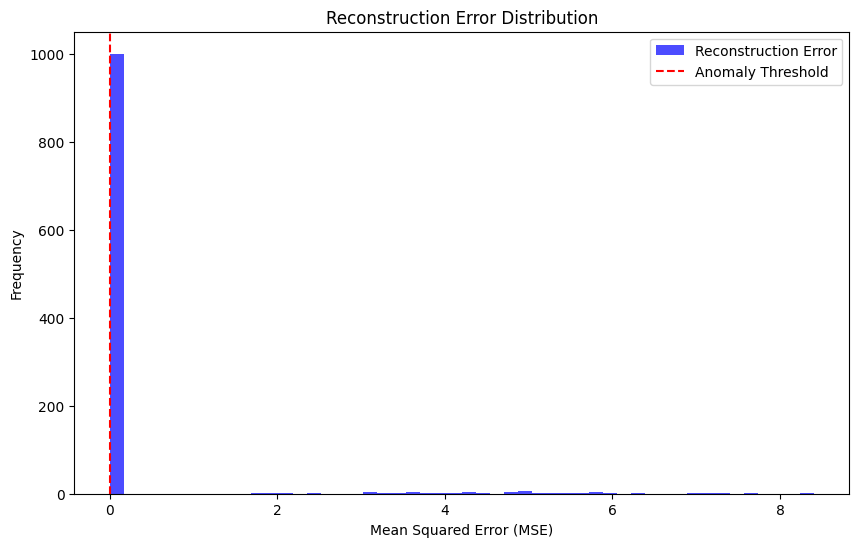

In [10]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Simulating communication metadata (normal and anomalous)
np.random.seed(42)
normal_data = np.random.normal(loc=100, scale=10, size=(1000, 3))  # Normal communication data (message size, transmission time, frequency)
anomalous_data = np.random.normal(loc=300, scale=50, size=(50, 3))  # Anomalous communication data

# Combine normal and anomalous data
data = np.vstack([normal_data, anomalous_data])
labels = np.array([0]*1000 + [1]*50)  # 0 = normal, 1 = anomalous

# Create a DataFrame for easy manipulation
df = pd.DataFrame(data, columns=["Message_Size", "Transmission_Time", "Frequency"])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Building the Autoencoder Model
model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='linear'))  # Same output shape as input for reconstruction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on normal data only (unsupervised)
model.fit(scaled_data[:1000], scaled_data[:1000], epochs=50, batch_size=32, verbose=0)

# Detect anomalies based on reconstruction error
reconstructed_data = model.predict(scaled_data)
mse = np.mean(np.square(scaled_data - reconstructed_data), axis=1)  # Mean Squared Error (MSE)

# Define an anomaly threshold (based on the reconstruction error)
threshold = np.percentile(mse, 95)  # Top 5% MSE is considered anomalous

# Flag anomalies
predictions = mse > threshold

# Evaluate the performance (classification report)
print(f"Anomaly Detection Performance:\n{classification_report(labels, predictions)}")

# Visualizing the MSE
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, color='blue', alpha=0.7, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [11]:
df

,Message_Size,Transmission_Time,Frequency
0,104.967142,98.617357,106.476885
1,115.230299,97.658466,97.658630
2,115.792128,107.674347,95.305256
3,105.425600,95.365823,95.342702
4,102.419623,80.867198,82.750822
...,...,...,...
1045,322.150107,347.577489,248.941877
1046,323.673595,286.617945,342.338539
1047,193.638629,295.045285,269.858967
1048,321.613148,323.502209,264.618705
